In [47]:
import numpy as np

import matplotlib.pyplot as plt

from photutils.datasets import apply_poisson_noise
from astropy.modeling import models
from astropy.wcs import WCS
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.nddata import StdDevUncertainty
import astropy.units as u

from specutils import Spectrum1D
from specutils.fitting import find_lines_threshold, find_lines_derivative, fit_generic_continuum

from specreduce.calibration_data import load_pypeit_calibration_lines
from specreduce.utils.synth_data import make_2d_arc_image, make_2d_spec_image
from specreduce.tracing import FlatTrace
from specreduce.extract import BoxcarExtract
from specreduce.line_matching import match_lines_wcs, find_arc_lines

In [2]:
%load_ext autoreload
%autoreload 2

np.random.seed(8675309)

In [4]:
nx = 3000
ny = 1000
const = 5
noise = 5
width = 5
center = ny / 2
x = np.arange(nx)
y = np.arange(ny)
xx, yy = np.meshgrid(x, y)
profile = models.Moffat1D()
wave_unit = u.Angstrom 
extent = [3500, 7000]

In [6]:
wcs = WCS(naxis=2)
wcs.wcs.ctype[0] = 'WAVE'
wcs.wcs.ctype[1] = 'PIXEL'
wcs.wcs.cunit[0] = wave_unit
wcs.wcs.cunit[1] = u.pixel
wcs.wcs.crval[0] = extent[0]
wcs.wcs.cdelt[0] = (extent[1] - extent[0]) / nx
wcs.wcs.crval[1] = 0
wcs.wcs.cdelt[1] = 1
wcs, wcs.spectral

(WCS Keywords
 
 Number of WCS axes: 2
 CTYPE : 'WAVE'  'PIXEL'  
 CRVAL : 3500.0  0.0  
 CRPIX : 0.0  0.0  
 PC1_1 PC1_2  : 1.0  0.0  
 PC2_1 PC2_2  : 0.0  1.0  
 CDELT : 1.1666666666666667  1.0  
 NAXIS : 0  0,
 WCS Keywords
 
 Number of WCS axes: 1
 CTYPE : 'WAVE'  
 CRVAL : 3.5000000000000004e-07  
 CRPIX : 0.0  
 PC1_1  : 1.0  
 CDELT : 1.1666666666666668e-10  
 NAXIS : 0  0)

In [7]:
ll = load_pypeit_calibration_lines(['HeI', 'NeI'])
ll

ion,wavelength,NIST,Instr,amplitude,Source
,Angstrom,,,,
str3,float64,int64,int64,int64,str25
HeI,3889.75,1,4,2565,kastb_600_PYPIT.json
HeI,4027.3292,1,4,153,kastb_600_PYPIT.json
HeI,4472.735,1,0,30,ALFOSC
HeI,4714.4644,1,4,275,kastb_600_PYPIT.json
HeI,4923.3053,1,4,656,kastb_600_PYPIT.json
HeI,5017.0772,1,4,2341,kastb_600_PYPIT.json
HeI,5877.249,1,0,1000,FORS2
HeI,6679.995,1,0,300,ALFOSC


In [9]:
#wcs.spectral.world_to_pixel(ll['wave'].value * ll['wave'].unit)
wcs.spectral.world_to_pixel(ll['wavelength'])

array([ 333.07142857,  450.99645714,  832.77285714, 1039.96948571,
       1218.97597143, 1299.35188571, 2036.642     , 2724.71      ,
       3056.54685714, 1318.27657143, 1569.50882857, 1578.35377143,
       1629.3398    , 1768.40942857, 1848.91031429, 1941.30071429,
       2016.80865714, 2042.0216    , 2095.98371429, 2122.30528571,
       2168.99994286, 2207.01654286, 2225.72908571, 2253.41085714,
       2265.93962857, 2283.54234286, 2329.57254286, 2371.76728571,
       2404.59962857, 2430.01065714, 2471.648     , 2488.15828571,
       2577.56471429, 2600.16045714, 2656.80748571, 2724.81757143,
       2758.05491429, 2940.18174286, 3028.44457143, 3149.78462857,
       3210.85408571, 3376.95448571, 3419.80014286, 3460.01325714,
       3928.7258    , 4181.7794    , 4282.73702857, 4412.78548571,
       4419.07991429, 4646.38537143, 4842.87105714, 4888.38637143,
       4995.34254286, 5080.11328571, 5109.11942857, 5132.67277143,
       5173.38225714, 6552.77557143])

In [10]:
profile.amplitude = 10
profile.alpha = 0.1
trace_mod = models.Chebyshev1D(degree=3, c0=0, c1=50, c2=100)
trace = yy - center + trace_mod(xx/nx)
z = const + profile(trace)
noisy = apply_poisson_noise(z)

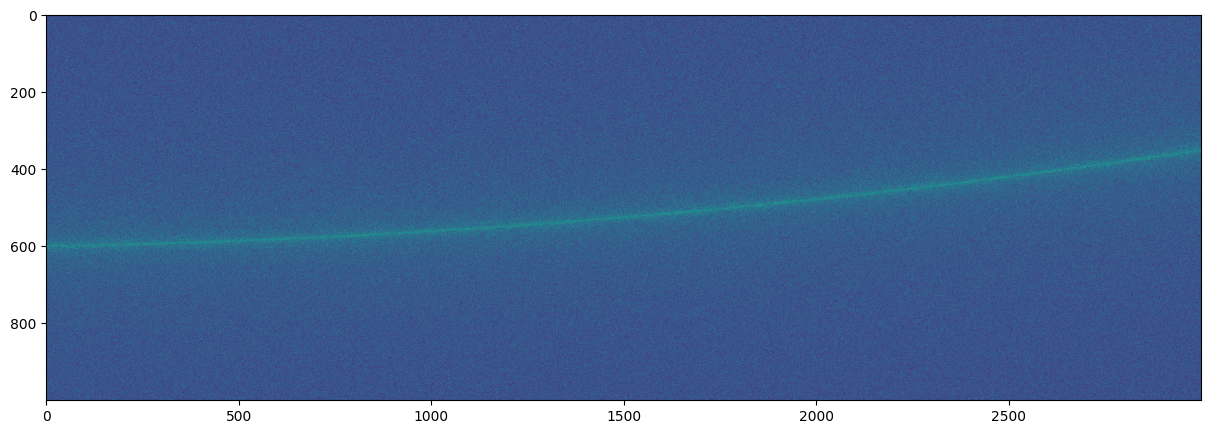

In [11]:
fig = plt.figure(figsize=(15, 5))
plt.imshow(noisy)
plt.show()

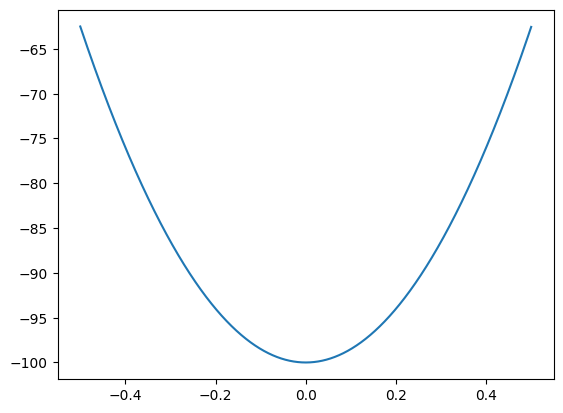

In [12]:
model2 = models.Legendre1D(degree=2, c0=-50, c1=0, c2=100)
model1 = models.Legendre1D(degree=1, c0=0, c1=100)
model = models.Chebyshev1D(degree=2, c0=50, c1=0, c2=100)
model3 = models.Legendre1D(degree=0)
x = (np.arange(3000)-1500)/3000
y = model2(x)
plt.plot(x, y)

In [13]:
xx + model((yy/2 - yy)/ny)

array([[-5.00000000e+01, -4.90000000e+01, -4.80000000e+01, ...,
         2.94700000e+03,  2.94800000e+03,  2.94900000e+03],
       [-4.99999500e+01, -4.89999500e+01, -4.79999500e+01, ...,
         2.94700005e+03,  2.94800005e+03,  2.94900005e+03],
       [-4.99998000e+01, -4.89998000e+01, -4.79998000e+01, ...,
         2.94700020e+03,  2.94800020e+03,  2.94900020e+03],
       ...,
       [-2.99550000e-01,  7.00450000e-01,  1.70045000e+00, ...,
         2.99670045e+03,  2.99770045e+03,  2.99870045e+03],
       [-1.99800000e-01,  8.00200000e-01,  1.80020000e+00, ...,
         2.99680020e+03,  2.99780020e+03,  2.99880020e+03],
       [-9.99500000e-02,  9.00050000e-01,  1.90005000e+00, ...,
         2.99690005e+03,  2.99790005e+03,  2.99890005e+03]])

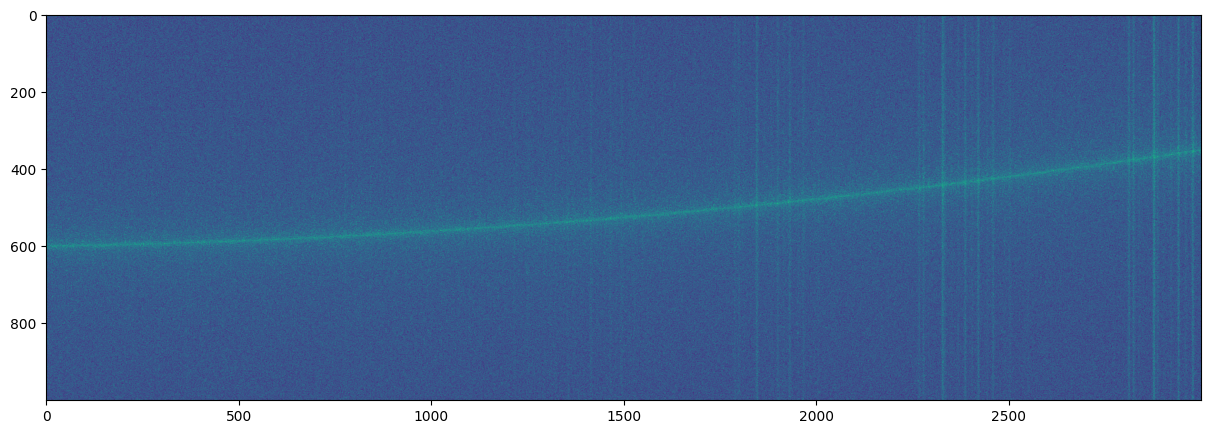

In [14]:
im = make_2d_spec_image()
fig = plt.figure(figsize=(15, 5))
plt.imshow(im)

In [15]:
im = make_2d_arc_image(linelists=['HeI', 'ArI', 'ArII'], line_fwhm=3, tilt_func=model2)

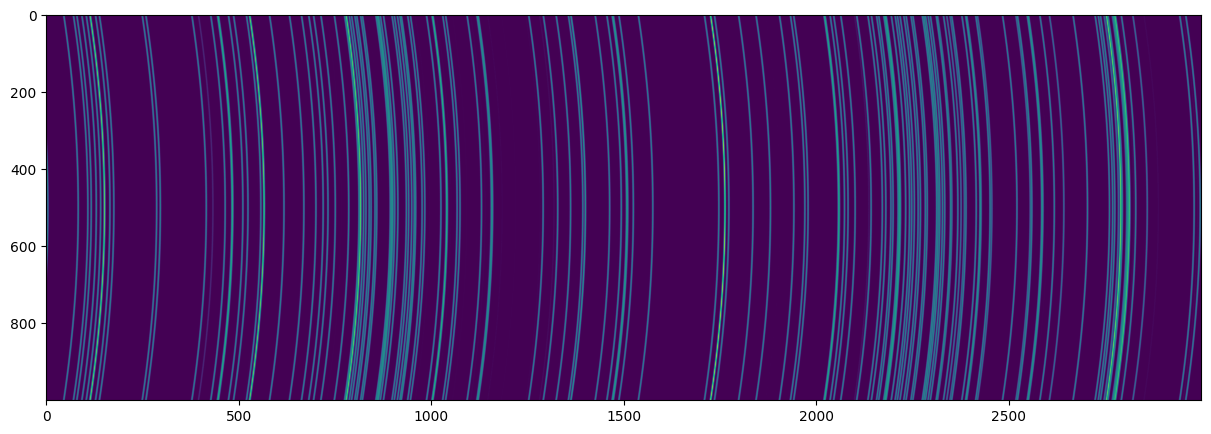

In [16]:
fig = plt.figure(figsize=(15, 5))
#ax = plt.subplot(projection=wcs)
#wave, pix = ax.coords
#wave.set_format_unit(u.um)
plt.imshow(im)

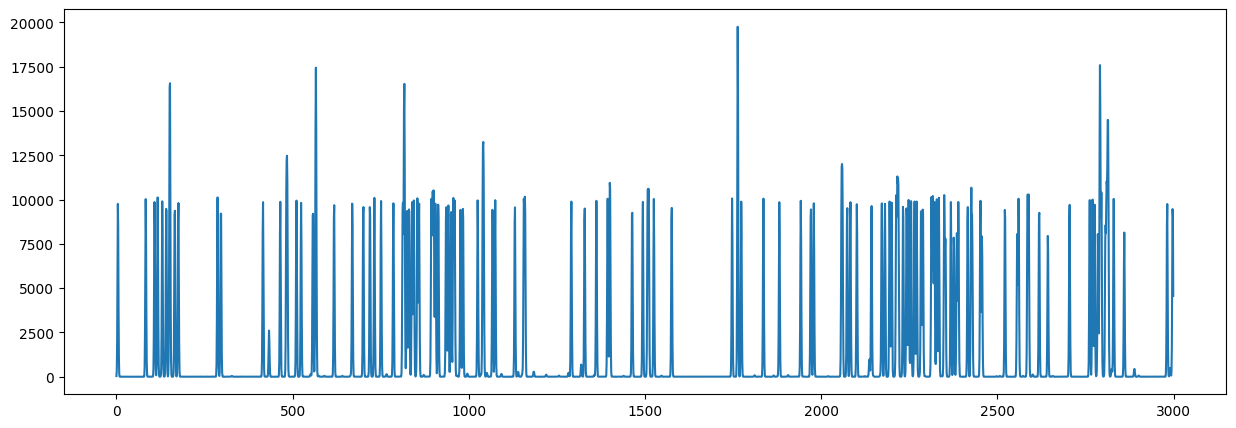

In [17]:
fig = plt.figure(figsize=(15, 5))
plt.plot(im.data[500, :])
plt.show()

In [18]:
non_linear_header = {
    'CTYPE1': 'AWAV-GRA',  # Grating dispersion function with air wavelengths
    'CUNIT1': 'Angstrom',  # Dispersion units
    'CRPIX1': 519.8,       # Reference pixel [pix]
    'CRVAL1': 7245.2,      # Reference value [Angstrom]
    'CDELT1': 2.956,       # Linear dispersion [Angstrom/pix]
    'PV1_0': 4.5e5,        # Grating density [1/m]
    'PV1_1': 1,            # Diffraction order
    'PV1_2': 27.0,         # Incident angle [deg]
    'PV1_3': 1.765,        # Reference refraction
    'PV1_4': -1.077e6,     # Refraction derivative [1/m]
    'CTYPE2': 'PIXEL',     # Spatial detector coordinates
    'CUNIT2': 'pix',       # Spatial units
    'CRPIX2': 1,           # Reference pixel
    'CRVAL2': 0,           # Reference value
    'CDELT2': 1            # Spatial units per pixel
}

linear_header = {
    'CTYPE1': 'AWAV',  # Grating dispersion function with air wavelengths
    'CUNIT1': 'Angstrom',  # Dispersion units
    'CRPIX1': 519.8,       # Reference pixel [pix]
    'CRVAL1': 7245.2,      # Reference value [Angstrom]
    'CDELT1': 2.956,       # Linear dispersion [Angstrom/pix]
    'CTYPE2': 'PIXEL',     # Spatial detector coordinates
    'CUNIT2': 'pix',       # Spatial units
    'CRPIX2': 1,           # Reference pixel
    'CRVAL2': 0,           # Reference value
    'CDELT2': 1            # Spatial units per pixel
}

non_linear_wcs = WCS(header=non_linear_header)
linear_wcs = WCS(header=linear_header)

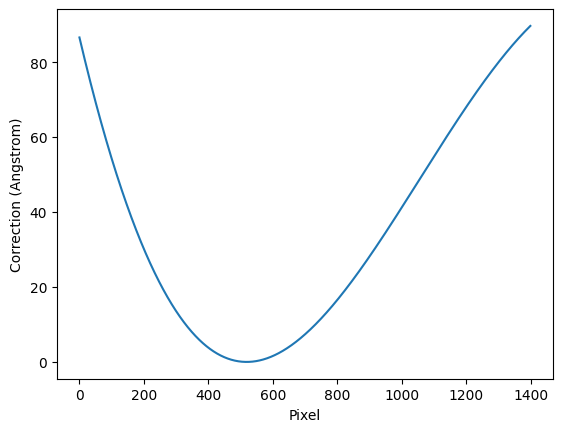

In [19]:
# this re-creates Paper III, Figure 5
pix_array = np.arange(1400)
nlin = non_linear_wcs.spectral.pixel_to_world(pix_array)
lin = linear_wcs.spectral.pixel_to_world(pix_array)
resid = (nlin - lin).to(u.Angstrom)
plt.plot(pix_array, resid)
plt.xlabel("Pixel")
plt.ylabel("Correction (Angstrom)")
plt.show()

In [20]:
linear_wcs.spectral.pixel_to_world(pix_array)

<SpectralCoord [5.7116272e-07, 5.7145832e-07, 5.7175392e-07, ..., 9.8411592e-07,
   9.8441152e-07, 9.8470712e-07] m>

In [21]:
linear_wcs.spectral

WCS Keywords

Number of WCS axes: 1
CTYPE : 'AWAV'  
CRVAL : 7.2452e-07  
CRPIX : 519.8  
PC1_1  : 1.0  
CDELT : 2.956e-10  
NAXIS : 0  0

In [22]:
tmod = models.Legendre1D(degree=2, c0=50, c1=0, c2=100)
match_im = make_2d_arc_image(nx=1400, ny=1024, linelists=['HeI', 'NeI'], wcs=linear_wcs, line_fwhm=5, tilt_func=tmod, amplitude_scale=5e-4)
arclist = load_pypeit_calibration_lines(['HeI', 'NeI'])['wavelength']
arclist_pix = linear_wcs.spectral.world_to_pixel(arclist)
arclist_pix = arclist_pix[(arclist_pix > 0) & (arclist_pix < 1400)]

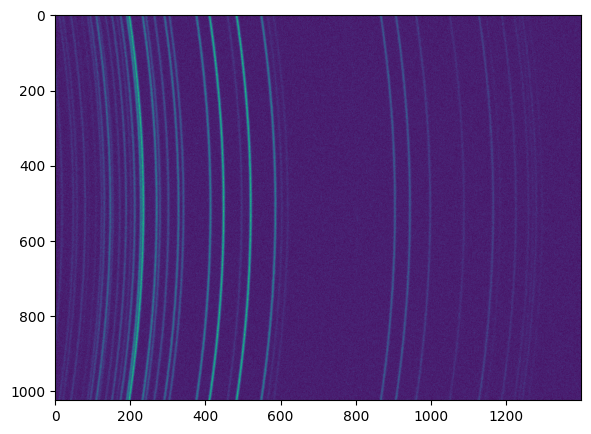

In [23]:
fig = plt.figure(figsize=(15, 5))
plt.imshow(match_im)

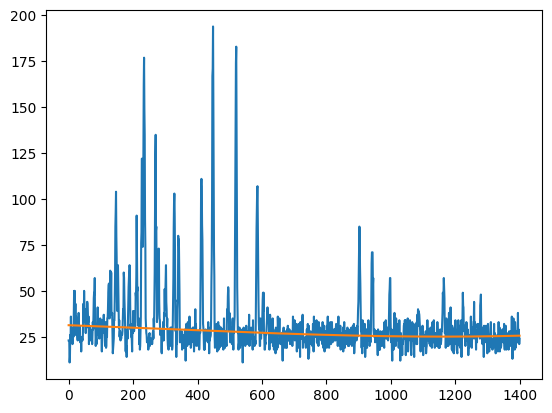

In [26]:
trace = FlatTrace(match_im, 512)
arc_sp = BoxcarExtract(match_im, trace, width=5).spectrum
arc_sp.uncertainty = StdDevUncertainty(np.sqrt(arc_sp.flux).value)
continuum = fit_generic_continuum(arc_sp, median_window=51)
fig = plt.figure()
plt.plot(arc_sp.spectral_axis, arc_sp.flux)
plt.plot(arc_sp.spectral_axis, continuum(arc_sp.spectral_axis))
#plt.vlines(arclist_pix, 0, arc_sp.flux.max().value, color='r')
plt.show()

In [27]:
arc_sub = Spectrum1D(spectral_axis=arc_sp.spectral_axis, flux=arc_sp.flux - continuum(arc_sp.spectral_axis))
arc_sub.uncertainty = arc_sp.uncertainty
detlines = find_lines_threshold(arc_sub, noise_factor=6)
detlines = detlines[detlines['line_type'] == 'emission']
detlines

line_center,line_type,line_center_index
pix,,
float64,str10,int64
147.0,emission,147
211.0,emission,211
228.0,emission,228
234.0,emission,234
270.0,emission,270
272.0,emission,272
328.0,emission,328
412.0,emission,412


In [28]:
np.diff(arclist_pix).shape

(44,)

In [40]:
tol = 5
diff = detlines['line_center'].value[:, np.newaxis] - arclist_pix
match_loc = np.where(np.abs(diff) < tol)
match_loc

(array([0, 1, 2, 3, 4, 4, 5, 6, 7, 8, 9]),
 array([12, 17, 19, 20,  1, 23, 24, 25, 26, 28, 29]))

In [42]:
detlines[match_loc[0]], arclist_pix[match_loc[1]]

(<QTable length=11>
 line_center line_type line_center_index
     pix                                
   float64      str8         int64      
 ----------- --------- -----------------
       147.0  emission               147
       212.0  emission               212
       234.0  emission               234
       269.0  emission               269
       328.0  emission               328
       328.0  emission               328
       341.0  emission               341
       414.0  emission               414
       448.0  emission               448
       519.0  emission               519
       585.0  emission               585,
 array([146.5276387 , 211.28278078, 234.232341  , 269.51904601,
        327.59397835, 327.63643437, 340.75446549, 412.63582544,
        447.47117727, 519.4641069 , 585.02019621]))

In [29]:
arclist

<Quantity [ 3889.75  ,  4027.3292,  4472.735 ,  4714.4644,  4923.3053,
            5017.0772,  5877.249 ,  6679.995 ,  7067.138 ,  5039.156 ,
            5332.2603,  5342.5794,  5402.0631,  5564.311 ,  5658.2287,
            5766.0175,  5854.1101,  5883.5252,  5946.481 ,  5977.1895,
            6031.6666,  6076.0193,  6097.8506,  6130.146 ,  6144.7629,
            6165.2994,  6219.0013,  6268.2285,  6306.5329,  6336.1791,
            6384.756 ,  6404.018 ,  6508.3255,  6534.6872,  6600.7754,
            6680.1205,  6718.8974,  6931.3787,  7034.352 ,  7175.9154,
            7247.1631,  7440.9469,  7490.9335,  7537.8488,  8084.6801,
            8379.9093,  8497.6932,  8649.4164,  8656.7599,  8921.9496,
            9151.1829,  9204.2841,  9329.0663,  9427.9655,  9461.806 ,
            9489.2849,  9536.7793, 11146.0715] Angstrom>

In [38]:
match_lines_wcs(pixel_positions=detlines['line_center'], catalog_wavelengths=arclist, spectral_wcs=non_linear_wcs.spectral, tolerance=5)

pixel_position,wavelength
pix,Angstrom
float64,float64
228.0,6404.018
270.0,6534.6872
272.0,6534.6872
328.0,6679.995
328.0,6680.1205
412.0,6931.3787
448.0,7034.352
520.0,7247.1631


In [53]:
cenlist = find_arc_lines(arc_sub, window=5)
match_lines_wcs(pixel_positions=cenlist['centroid'], catalog_wavelengths=arclist, spectral_wcs=non_linear_wcs.spectral, tolerance=5)

pixel_position,wavelength
pix,Angstrom
float64,float64
269.66128373834545,6534.6872
269.6612208621255,6534.6872
327.6428532498186,6679.995
327.6428532498186,6680.1205
341.1841158032577,6718.8974
412.3934664146378,6931.3787
447.5035484427951,7034.352
519.4431661145901,7247.1631
